<a href="https://colab.research.google.com/github/alimomennasab/ASL-Translator/blob/main/CS4200_3DCNN_croppedhands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data Preprocessing

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled pro

In [ ]:
# Data preprocessing: extract right and left hands from both videos

import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm

CROP_SIZE = 112
TARGET_FRAMES = 64

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def extract_hand_boxes(frame, results):
    h, w = frame.shape[:2]
    left_box, right_box = None, None

    if results.multi_hand_landmarks and results.multi_handedness:
        for lm, handness in zip(results.multi_hand_landmarks, results.multi_handedness):
            label = handness.classification[0].label.lower()

            xs = [p.x for p in lm.landmark]
            ys = [p.y for p in lm.landmark]

            x1 = int(w * min(xs))
            x2 = int(w * max(xs))
            y1 = int(h * min(ys))
            y2 = int(h * max(ys))

            # bounding box padding
            pad = 20
            x1 = max(0, x1 - pad)
            y1 = max(0, y1 - pad)
            x2 = min(w, x2 + pad)
            y2 = min(h, y2 + pad)

            box = (x1, y1, x2, y2)

            if label == "left":
                left_box = box
            else:
                right_box = box

    return left_box, right_box


def extract_crops_from_video(path):
    frames = []
    cap = cv2.VideoCapture(path)

    while True:
        ret, f = cap.read()
        if not ret:
            break
        frames.append(f)
    cap.release()

    # 64 frames in each vid
    if len(frames) == 0:
        print(f"[WARNING] Empty or unreadable video: {path}")
        return None, None
    elif len(frames) > TARGET_FRAMES:
        idxs = np.linspace(0, len(frames)-1, TARGET_FRAMES).astype(int)
        frames = [frames[i] for i in idxs]
    elif len(frames) < TARGET_FRAMES:
        frames = frames + [frames[-1]]*(TARGET_FRAMES - len(frames))

    left_crops = []
    right_crops = []

    for f in frames:
        rgb = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb)

        lbox, rbox = extract_hand_boxes(f, results)

        # left
        if lbox is None:
            left_c = np.zeros((CROP_SIZE, CROP_SIZE, 3), dtype=np.uint8)
        else:
            x1,y1,x2,y2 = lbox
            left = f[y1:y2, x1:x2]
            left_c = cv2.resize(left, (CROP_SIZE, CROP_SIZE))

        # right
        if rbox is None:
            right_c = np.zeros((CROP_SIZE, CROP_SIZE, 3), dtype=np.uint8)
        else:
            x1,y1,x2,y2 = rbox
            right = f[y1:y2, x1:x2]
            right_c = cv2.resize(right, (CROP_SIZE, CROP_SIZE))

        left_crops.append(left_c)
        right_crops.append(right_c)

    return np.stack(left_crops), np.stack(right_crops)


def process_hands(video_root, output_root):
    for label in tqdm(os.listdir(video_root)):
        ldir = os.path.join(video_root, label)
        if not os.path.isdir(ldir):
            continue

        out_label_dir = os.path.join(output_root, label)
        os.makedirs(out_label_dir, exist_ok=True)

        for f in os.listdir(ldir):
            if not f.endswith(".mp4"):
                continue

            video_path = os.path.join(ldir, f)
            base = f.replace(".mp4","")

            left, right = extract_crops_from_video(video_path)

            if left is None:
                print(f"Video unreadable: {video_path}")
                continue

            np.save(os.path.join(out_label_dir, base+"_left.npy"), left)
            np.save(os.path.join(out_label_dir, base+"_right.npy"), right)

# Processing
HAND_TRAIN_INPUT = "/content/drive/MyDrive/WLASL/WLASL100_train"
HAND_VAL_INPUT = "/content/drive/MyDrive/WLASL/WLASL100_val"
HAND_TEST_INPUT = "/content/drive/MyDrive/WLASL/WLASL100_test"

HAND_TRAIN_OUTPUT = "/content/drive/MyDrive/WLASL/HAND_TRAIN"
HAND_VAL_OUTPUT = "/content/drive/MyDrive/WLASL/HAND_VAL"
HAND_TEST_OUTPUT = "/content/drive/MyDrive/WLASL/HAND_TEST"
os.makedirs(HAND_TRAIN_OUTPUT, exist_ok=True)
os.makedirs(HAND_VAL_OUTPUT, exist_ok=True)
os.makedirs(HAND_TEST_OUTPUT, exist_ok=True)

#process_hands(HAND_TRAIN_INPUT, HAND_TRAIN_OUTPUT)
process_hands(HAND_VAL_INPUT, HAND_VAL_OUTPUT)
process_hands(HAND_TEST_INPUT, HAND_TEST_OUTPUT)

  3%|▎         | 3/100 [00:19<10:26,  6.46s/it]

[WARNING] Empty or unreadable video: /content/drive/MyDrive/WLASL/WLASL100_val/orange/40118.mp4


100%|██████████| 86/86 [06:43<00:00,  4.70s/it]


Data loading

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

CROP_SIZE = 112
SEQ_LEN = 64

img_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

class HandCropDataset(Dataset):
    def __init__(self, root_dir, class_map=None, train=True):
        self.root_dir = root_dir
        self.samples = []
        self.train = train

        # build class map
        if class_map is None:
            labels = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
            self.class_to_idx = {lbl:i for i,lbl in enumerate(labels)}
        else:
            self.class_to_idx = class_map["class_to_idx"]

        self.idx_to_class = list(self.class_to_idx.keys())

        # append samples
        for lbl in self.class_to_idx:
            lbl_dir = os.path.join(root_dir, lbl)
            if not os.path.isdir(lbl_dir):
                print(f"Label directory not found: {lbl_dir}. Skipping.")
                continue

            idx = self.class_to_idx[lbl]

            for f in os.listdir(lbl_dir):
                if f.endswith("_left.npy"):
                    base = f.replace("_left.npy", "")
                    left_path = os.path.join(lbl_dir, f)
                    right_path = os.path.join(lbl_dir, base + "_right.npy")

                    if os.path.exists(right_path):
                        self.samples.append((left_path, right_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        left_path, right_path, label = self.samples[idx]

        left = np.load(left_path) # (num_frames, H, W, 3)
        right = np.load(right_path)

        left_ts  = torch.stack([img_tf(Image.fromarray(f)) for f in left])
        right_ts = torch.stack([img_tf(Image.fromarray(f)) for f in right])

        return left_ts, right_ts, torch.tensor(label, dtype=torch.long)


TRAIN_DIR = "/content/drive/MyDrive/WLASL/HAND_TRAIN"
VAL_DIR = "/content/drive/MyDrive/WLASL/HAND_VAL"

train_ds = HandCropDataset(TRAIN_DIR)
val_ds = HandCropDataset(VAL_DIR, class_map={'class_to_idx': train_ds.class_to_idx})

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")

num_classes = len(train_ds.idx_to_class)


Label directory not found: /content/drive/MyDrive/WLASL/HAND_VAL/orange. Skipping.
Train samples: 470
Val samples: 197


Model Definition

In [ ]:
import torch.nn as nn
import torch
from torchvision import models

class HandCNN(nn.Module):
    def __init__(self, num_classes, feat_dim=256):
        super().__init__()

        m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.cnn = m.features # feature extraction layers
        self.pool = nn.AdaptiveAvgPool2d(1) # adaptive average pooling to get a fixed size feature vector (1 x 1)

        in_feats = m.classifier[0].in_features

        self.fc1 = nn.Linear(in_feats, feat_dim)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)

        self.clf = nn.Linear(feat_dim * 2, num_classes) # feat_dim * 2 because left and right hand features are concatenated

    def forward(self, left, right):
        B, T, C, H, W = left.shape

        # combine batch size and time steps to treat each frame as an independent image
        L = left.view(B*T, C, H, W)
        R = right.view(B*T, C, H, W)

        # pass each hand's frames through the feature extractor
        Lf = self.pool(self.cnn(L)).squeeze() # (B*T, CNN_features_dim, 1, 1) -> (B*T, CNN_features_dim)
        Rf = self.pool(self.cnn(R)).squeeze() # (B*T, CNN_features_dim, 1, 1) -> (B*T, CNN_features_dim)
        Lf = self.dropout(self.relu(self.fc1(Lf)))
        Rf = self.dropout(self.relu(self.fc1(Rf)))

        # reshape features back to include the time dimension, average features over time
        Lf = Lf.view(B, T, -1).mean(dim=1) # (B, T, feat_dim) -> (B, feat_dim)
        Rf = Rf.view(B, T, -1).mean(dim=1)

        # concatenate the averaged left and right hand features
        fused = torch.cat([Lf, Rf], dim=1) # (B, feat_dim * 2)

        # classify with fused features
        return self.clf(fused)

Training loop

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 84.8MB/s]
Epoch 1/40: 100%|██████████| 59/59 [02:48<00:00,  2.85s/it]


Epoch 1: Train Acc=1.70% | Val Acc=2.03%
Checkpoint saved at epoch 1


Epoch 2/40: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s]


Epoch 2: Train Acc=1.91% | Val Acc=2.03%
Checkpoint saved at epoch 2


Epoch 3/40: 100%|██████████| 59/59 [00:41<00:00,  1.42it/s]


Epoch 3: Train Acc=2.98% | Val Acc=1.02%
Checkpoint saved at epoch 3


Epoch 4/40: 100%|██████████| 59/59 [00:38<00:00,  1.54it/s]


Epoch 4: Train Acc=4.47% | Val Acc=2.03%
Checkpoint saved at epoch 4


Epoch 5/40: 100%|██████████| 59/59 [00:38<00:00,  1.52it/s]


Epoch 5: Train Acc=5.53% | Val Acc=3.05%
Checkpoint saved at epoch 5


Epoch 6/40: 100%|██████████| 59/59 [00:39<00:00,  1.51it/s]


Epoch 6: Train Acc=7.45% | Val Acc=4.06%
Checkpoint saved at epoch 6


Epoch 7/40: 100%|██████████| 59/59 [00:38<00:00,  1.54it/s]


Epoch 7: Train Acc=10.00% | Val Acc=5.08%
Checkpoint saved at epoch 7


Epoch 8/40: 100%|██████████| 59/59 [00:38<00:00,  1.53it/s]


Epoch 8: Train Acc=12.55% | Val Acc=4.06%
Checkpoint saved at epoch 8


Epoch 9/40: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Epoch 9: Train Acc=14.89% | Val Acc=4.57%
Checkpoint saved at epoch 9


Epoch 10/40: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s]


Epoch 10: Train Acc=20.00% | Val Acc=5.08%
Checkpoint saved at epoch 10


Epoch 11/40: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


Epoch 11: Train Acc=20.64% | Val Acc=5.58%
Checkpoint saved at epoch 11


Epoch 12/40: 100%|██████████| 59/59 [00:39<00:00,  1.51it/s]


Epoch 12: Train Acc=25.53% | Val Acc=6.60%
Checkpoint saved at epoch 12


Epoch 13/40: 100%|██████████| 59/59 [00:41<00:00,  1.44it/s]


Epoch 13: Train Acc=28.09% | Val Acc=8.63%
Checkpoint saved at epoch 13


Epoch 14/40: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


Epoch 14: Train Acc=32.34% | Val Acc=7.61%
Checkpoint saved at epoch 14


Epoch 15/40: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


Epoch 15: Train Acc=36.17% | Val Acc=7.61%
Checkpoint saved at epoch 15


Epoch 16/40: 100%|██████████| 59/59 [00:41<00:00,  1.41it/s]


Epoch 16: Train Acc=40.21% | Val Acc=10.15%
Checkpoint saved at epoch 16


Epoch 17/40: 100%|██████████| 59/59 [00:40<00:00,  1.45it/s]


Epoch 17: Train Acc=47.23% | Val Acc=10.66%
Checkpoint saved at epoch 17


Epoch 18/40: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Epoch 18: Train Acc=47.02% | Val Acc=10.66%
Checkpoint saved at epoch 18


Epoch 19/40: 100%|██████████| 59/59 [00:41<00:00,  1.42it/s]


Epoch 19: Train Acc=54.47% | Val Acc=12.69%
Checkpoint saved at epoch 19


Epoch 20/40: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s]


Epoch 20: Train Acc=56.60% | Val Acc=12.18%
Checkpoint saved at epoch 20


Epoch 21/40: 100%|██████████| 59/59 [00:40<00:00,  1.47it/s]


Epoch 21: Train Acc=60.00% | Val Acc=13.20%
Checkpoint saved at epoch 21


Epoch 22/40: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


Epoch 22: Train Acc=62.77% | Val Acc=16.24%
Checkpoint saved at epoch 22


Epoch 23/40: 100%|██████████| 59/59 [00:39<00:00,  1.48it/s]


Epoch 23: Train Acc=70.64% | Val Acc=13.71%
Checkpoint saved at epoch 23


Epoch 24/40: 100%|██████████| 59/59 [00:39<00:00,  1.50it/s]


Epoch 24: Train Acc=72.13% | Val Acc=16.24%
Checkpoint saved at epoch 24


Epoch 25/40: 100%|██████████| 59/59 [00:39<00:00,  1.50it/s]


Epoch 25: Train Acc=75.11% | Val Acc=15.74%
Checkpoint saved at epoch 25


Epoch 26/40: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s]


Epoch 26: Train Acc=76.17% | Val Acc=14.72%
Checkpoint saved at epoch 26


Epoch 27/40: 100%|██████████| 59/59 [00:38<00:00,  1.52it/s]


Epoch 27: Train Acc=78.09% | Val Acc=16.24%
Checkpoint saved at epoch 27


Epoch 28/40: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Epoch 28: Train Acc=80.21% | Val Acc=17.26%
Checkpoint saved at epoch 28


Epoch 29/40: 100%|██████████| 59/59 [00:40<00:00,  1.44it/s]


Epoch 29: Train Acc=81.06% | Val Acc=14.21%
Checkpoint saved at epoch 29


Epoch 30/40: 100%|██████████| 59/59 [00:39<00:00,  1.51it/s]


Epoch 30: Train Acc=84.89% | Val Acc=16.24%
Checkpoint saved at epoch 30


Epoch 31/40: 100%|██████████| 59/59 [00:39<00:00,  1.51it/s]


Epoch 31: Train Acc=86.38% | Val Acc=17.77%
Checkpoint saved at epoch 31


Epoch 32/40: 100%|██████████| 59/59 [00:42<00:00,  1.38it/s]


Epoch 32: Train Acc=86.38% | Val Acc=17.26%
Checkpoint saved at epoch 32


Epoch 33/40: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Epoch 33: Train Acc=87.02% | Val Acc=17.77%
Checkpoint saved at epoch 33


Epoch 34/40: 100%|██████████| 59/59 [00:39<00:00,  1.50it/s]


Epoch 34: Train Acc=88.30% | Val Acc=18.27%
Checkpoint saved at epoch 34


Epoch 35/40: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s]


Epoch 35: Train Acc=89.15% | Val Acc=16.24%
Checkpoint saved at epoch 35


Epoch 36/40: 100%|██████████| 59/59 [00:39<00:00,  1.51it/s]


Epoch 36: Train Acc=89.79% | Val Acc=17.26%
Checkpoint saved at epoch 36


Epoch 37/40: 100%|██████████| 59/59 [00:37<00:00,  1.57it/s]


Epoch 37: Train Acc=89.79% | Val Acc=17.26%
Checkpoint saved at epoch 37


Epoch 38/40: 100%|██████████| 59/59 [00:40<00:00,  1.46it/s]


Epoch 38: Train Acc=92.98% | Val Acc=18.78%
Checkpoint saved at epoch 38


Epoch 39/40: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Epoch 39: Train Acc=92.13% | Val Acc=20.81%
Checkpoint saved at epoch 39


Epoch 40/40: 100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


Epoch 40: Train Acc=93.62% | Val Acc=21.32%
Checkpoint saved at epoch 40


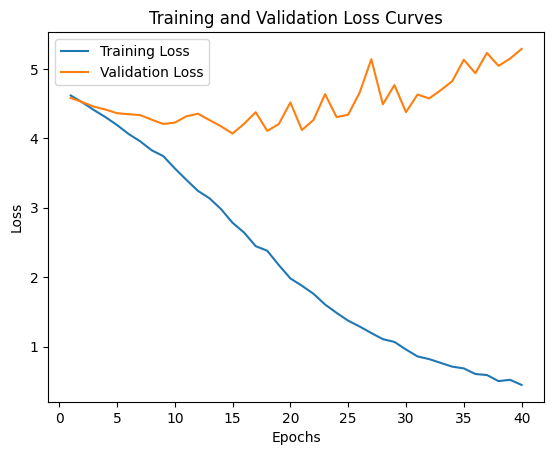

Final model saved to: /content/drive/MyDrive/HANDCNN_final_run0.pt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

def plot_losses(train_losses: list, val_losses: list):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


# setup
num_classes = len(train_ds.idx_to_class)
class_names = train_ds.idx_to_class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HandCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS = 40
start_epoch = 0
run = 0

CHECKPOINT_PATH = f"/content/drive/MyDrive/HANDCNN_checkpoint_run{run}.pt"
MODEL_PATH      = f"/content/drive/MyDrive/HANDCNN_final_run{run}.pt"
LABELS_PATH     = f"/content/drive/MyDrive/HANDCNN_labels_run{run}.json"

# load model checkpoint
if os.path.exists(CHECKPOINT_PATH):
    print("Loading checkpoint")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    train_losses = checkpoint["train_losses"]
    val_losses = checkpoint["val_losses"]
    print(f"Resuming from epoch {start_epoch}")
else:
    train_losses, val_losses = [], []


# training loop
for epoch in range(start_epoch, EPOCHS):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for left, right, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        left, right, labels = left.to(device), right.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(left, right)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for left, right, labels in val_loader:
            left, right, labels = left.to(device), right.to(device), labels.to(device)

            outputs = model(left, right)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100. * val_correct / val_total

    print(f"Epoch {epoch+1}: Train Acc={100.*correct/total:.2f}% | Val Acc={val_acc:.2f}%")

    # save checkpoint
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses
    }
    torch.save(checkpoint, CHECKPOINT_PATH)
    print(f"Checkpoint saved at epoch {epoch+1}")



plot_losses(train_losses, val_losses)

torch.save(model.state_dict(), MODEL_PATH)
with open(LABELS_PATH, "w") as f:
    json.dump(class_names, f)

print("Final model saved to:", MODEL_PATH)
